In [1]:
# Load necessary packages
import numpy as np
import pandas as pd
import matplotlib as mpl
from plotnine import *

# Visualization modules
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

# Modeling and evaluation modules 
from sklearn.ensemble import RandomForestClassifier 
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

import warnings
warnings.filterwarnings("ignore")

# Module for saving model
import joblib 

# Set seed for reproducibility 
SEED = 42

In [2]:
df = pd.read_csv("df_model.csv")
print(f"Original Shape: {df.shape}")
df.head()

Original Shape: (20000, 7)


,type,amount,oldbalanceOrig,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
0,PAYMENT,600.0,170136.0,160296.36,0.0,0.0,0
1,PAYMENT,10000.0,21249.0,19384.72,0.0,0.0,0
2,PAYMENT,1000.0,181.0,0.00,0.0,0.0,0
3,PAYMENT,700.0,181.0,0.00,21182.0,0.0,0
4,PAYMENT,1000.0,41554.0,29885.86,0.0,0.0,0


In [3]:
y = df["isFraud"]
X = df.drop("isFraud", axis=1)

In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.3, 
    stratify=y,
    random_state=42
)

In [5]:
categorical = ["type"]
numeric = ["amount", "oldbalanceOrig", "newbalanceOrig", "oldbalanceDest", "newbalanceDest"]

In [6]:
#setting categorical and numerical data

categorical = ["type"]
numeric = ["amount", "oldbalanceOrig", "newbalanceOrig", "oldbalanceDest", "newbalanceDest"]

In [7]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder


In [8]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric),
        ("cat", OneHotEncoder(drop="first"), categorical)
    ],
    remainder="drop"
)

In [9]:
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline

xgb_clf = XGBClassifier(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=5,       # handles fraud class imbalance
    eval_metric="logloss",
    random_state=42
)


In [10]:
pipeline = Pipeline([
    ("prep", preprocessor),
    ("clf", xgb_clf)
])

In [11]:
pipeline.fit(X_train, y_train)

,steps,"[('prep', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [12]:
y_pred = pipeline.predict(X_test)


In [13]:
from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.99      0.99      0.99      5880
           1       0.62      0.55      0.58       120

    accuracy                           0.98      6000
   macro avg       0.81      0.77      0.79      6000
weighted avg       0.98      0.98      0.98      6000



In [14]:
# Confusion Matrix
print(confusion_matrix(y_test, y_pred))


[[5840   40]
 [  54   66]]


In [15]:
# Accuracy Score
print("Accuracy:", pipeline.score(X_test, y_test)*100)

Accuracy: 98.43333333333332


In [16]:
import joblib
joblib.dump(pipeline, "XGBoost_fraud_model.pkl")

['XGBoost_fraud_model.pkl']

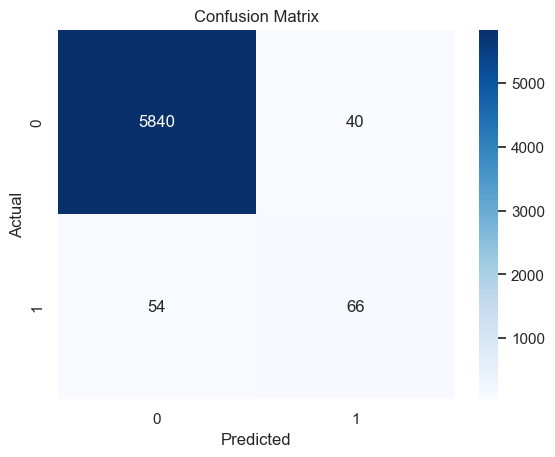

In [21]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


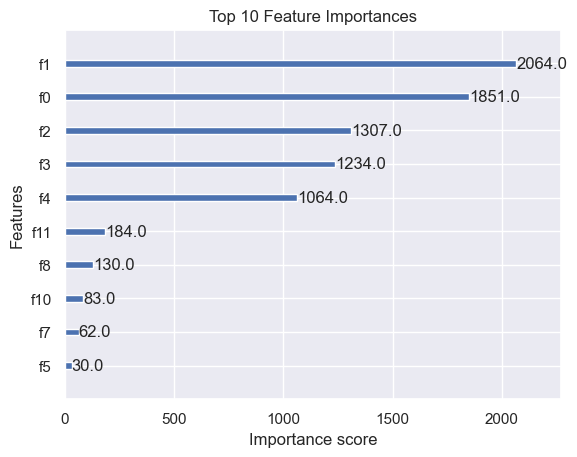

In [18]:
import xgboost as xgb

model = pipeline.named_steps["clf"]
xgb.plot_importance(model, max_num_features=10)
plt.title("Top 10 Feature Importances")
plt.show()


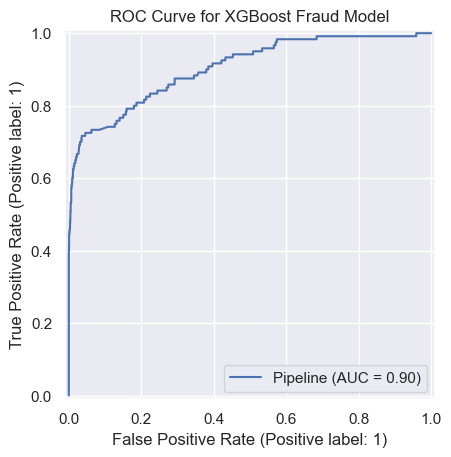

In [19]:
from sklearn.metrics import RocCurveDisplay

RocCurveDisplay.from_estimator(pipeline, X_test, y_test)
plt.title("ROC Curve for XGBoost Fraud Model")
plt.show()